### Online Colab Demo: https://colab.research.google.com/drive/14Dqg7oeBkFEtchaHLNpig2BcdkZEogba
### Hugging Face Spaces Demo: https://huggingface.co/spaces/ZhengPeng7/BiRefNet_demo

In [1]:
# Imports
from PIL import Image
import torch
from torchvision import transforms
from IPython.display import display

import sys
sys.path.insert(0, "../")
from models.birefnet import BiRefNet


# Load Model
# Option 2 and Option 3 is better for local running -- we can modify codes locally.

# # # Option 1: loading BiRefNet with weights:
# from transformers import AutoModelForImageSegmentation
# birefnet = AutoModelForImageSegmentation.from_pretrained('zhengpeng7/BiRefNet', trust_remote_code=True)

# Option-2: loading weights with BiRefNet codes:
# birefnet = BiRefNet.from_pretrained(
#     [
#         'zhengpeng7/BiRefNet',
#         'zhengpeng7/BiRefNet-portrait',
#         'zhengpeng7/BiRefNet-legacy', 'zhengpeng7/BiRefNet-DIS5K-TR_TEs', 'zhengpeng7/BiRefNet-DIS5K', 'zhengpeng7/BiRefNet-HRSOD', 'zhengpeng7/BiRefNet-COD',
#         'zhengpeng7/BiRefNet_lite',     # Modify the `bb` in `config.py` to `swin_v1_tiny`.
#     ][0]
# )

# # Option-3: Loading model and weights from local disk:
from utils import check_state_dict

birefnet = BiRefNet(bb_pretrained=False)
# state_dict = torch.load('saved_models/BiRefNet-general-epoch_244.pth', map_location='cpu', weights_only=True)
state_dict = torch.load('saved_models/BiRefNet-portrait-epoch_150.pth', map_location='cpu', weights_only=True)
state_dict = check_state_dict(state_dict)
birefnet.load_state_dict(state_dict)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.set_float32_matmul_precision(['high', 'highest'][0])

birefnet.to(device)
birefnet.eval()
print('BiRefNet is ready to use.')

# VD: half precision inference returns empty (all black) mask
# birefnet.half()
# print('Using half precision!')

# Input Data
transform_image = transforms.Compose([
    transforms.Resize((1024, 1024)),
    # transforms.Resize((2048, 2048)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

/mnt/d/Builds/myenv_pytorch/lib/python3.12/site-packages/onnxscript/converter.py:820: FutureWarning: 'onnxscript.values.Op.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()
/mnt/d/Builds/myenv_pytorch/lib/python3.12/site-packages/onnxscript/converter.py:820: FutureWarning: 'onnxscript.values.OnnxFunction.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()


BiRefNet is ready to use.


Processing /mnt/d/Data/Test Images/Segmentation-Validation-Images/DollywoodGuestImagesConfidential/0000293730-File006386008898611454460000000005.JPG ...
Processing /mnt/d/Data/Test Images/Segmentation-Validation-Images/DollywoodGuestImagesConfidential/0000293736-File006386008898928614470000000011.JPG ...
Processing /mnt/d/Data/Test Images/Segmentation-Validation-Images/DollywoodGuestImagesConfidential/0000293802-File006386009128188235890000000125.JPG ...
Processing /mnt/d/Data/Test Images/Segmentation-Validation-Images/DollywoodGuestImagesConfidential/0000293806-File006386009128391346190000000129.JPG ...
Processing /mnt/d/Data/Test Images/Segmentation-Validation-Images/DollywoodGuestImagesConfidential/0000293855-File006386009270294209400000000212.JPG ...
Processing /mnt/d/Data/Test Images/Segmentation-Validation-Images/DollywoodGuestImagesConfidential/0000293891-File006386009411601071680000000269.JPG ...
Processing /mnt/d/Data/Test Images/Segmentation-Validation-Images/DollywoodGuestIm

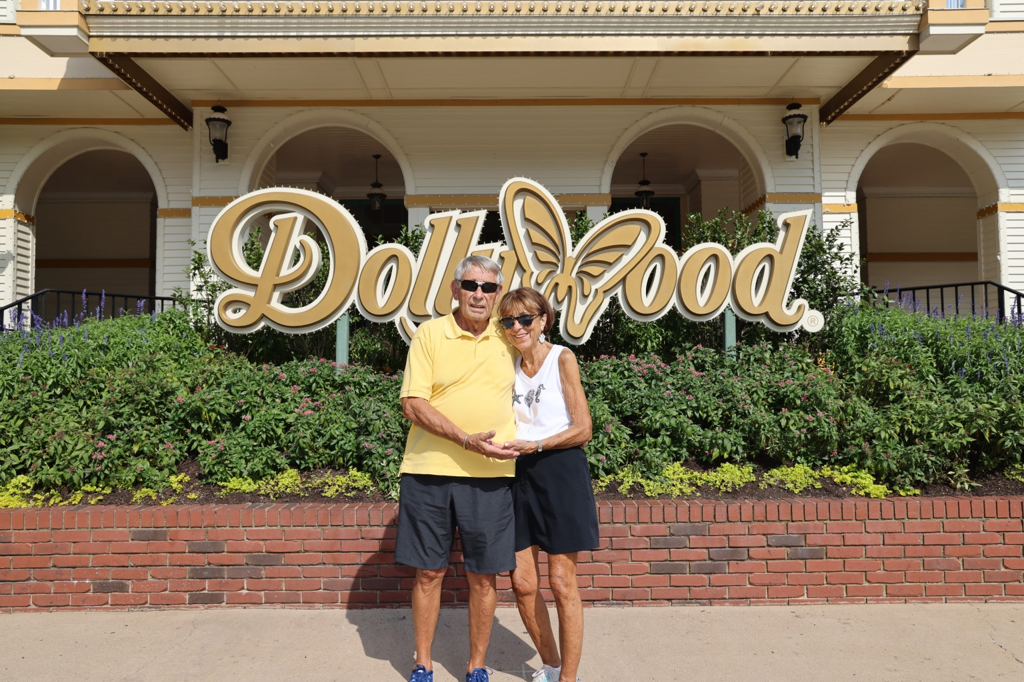

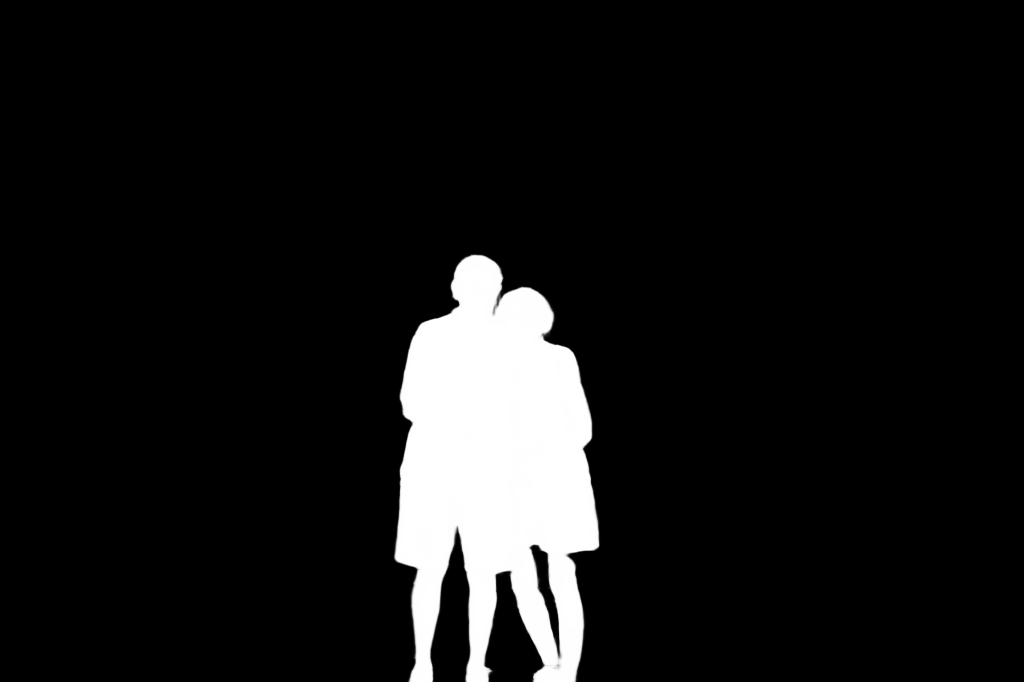

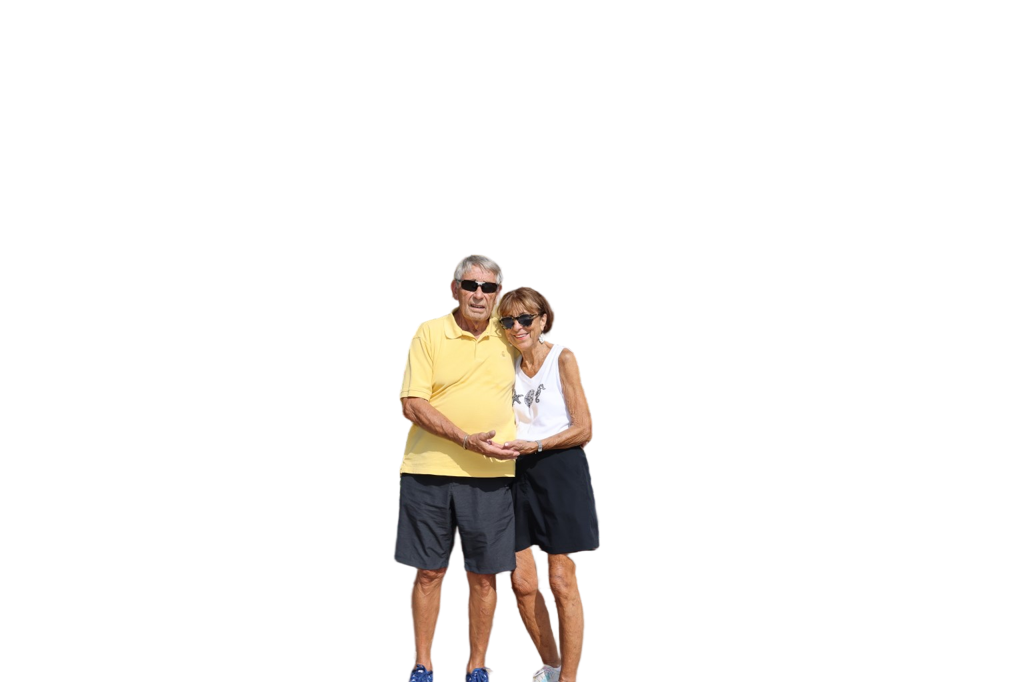

In [4]:
import os
from glob import glob
from image_proc import refine_foreground, generate_visual

src_dir = '/mnt/d/Data/Test Images/Segmentation-Validation-Images/DollywoodGuestImagesConfidential'
image_paths = glob(os.path.join(src_dir, '*.JPG'))
dst_dir = '/mnt/d/Data/Test Image Dumps/BGR/dumps/BiRefNet-portrait-DW-lowres'

gt_dir  = os.path.join(dst_dir,'gt')
vis_dir = os.path.join(dst_dir,'vis')

os.makedirs(gt_dir,  exist_ok=True)
os.makedirs(vis_dir, exist_ok=True)
for image_path in image_paths:
    print('Processing {} ...'.format(image_path))
    image = Image.open(image_path)
    image = image.convert("RGB") if image.mode != "RGB" else image
    input_images = transform_image(image).unsqueeze(0).to(device)
    # input_images = input_images.half()

    # Prediction
    with torch.no_grad():
        preds = birefnet(input_images)[-1].sigmoid().cpu()
    pred = preds[0].squeeze()

    # Show Results (mask)
    pred_pil = transforms.ToPILImage()(pred)

    pred_pil.resize(image.size).save(image_path.replace(src_dir, gt_dir))

    image_masked = refine_foreground(image, pred_pil)
    image_masked.putalpha(pred_pil.resize(image.size))
    
    # Show Results (visualization)
    image_vis = generate_visual(image, image_masked)
    image_vis.save(image_path.replace(src_dir, vis_dir))

# Visualize the last sample:
# Scale proportionally with max length to 1024 for faster showing
scale_ratio = 1024 / max(image.size)
scaled_size = (int(image.size[0] * scale_ratio), int(image.size[1] * scale_ratio))

display(image.resize(scaled_size))
display(pred_pil.resize(scaled_size))
display(image_masked.resize(scaled_size))

In [13]:
%%timeit
with torch.no_grad():
    preds = birefnet(input_images)[-1].sigmoid().cpu()

12.6 s ± 414 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
